On cherche à résoudre l'équation de l'enveloppe de l'onde propagé suivante :

$$\dfrac{\partial A}{\partial z} (z,t) = -i\dfrac{\beta_2}{2} \dfrac{\partial^2 A}{\partial t^2} (z,t) $$
tel que :
$$\beta_2 = -\dfrac{D\lambda^2}{2\pi c} $$

On applique la transformée de Fourier à cette équation :
$$\mathcal{F}\left\{ \dfrac{\partial A}{\partial z} \right\}(z,\omega) = -i\dfrac{\beta_2}{2} \mathcal{F}\left\{\dfrac{\partial^2 A}{\partial t^2} \right\}(z,\omega) \Longrightarrow 
\dfrac{\partial }{\partial z} \mathcal{F}\left\{ A \right\}(z,\omega) = -i\dfrac{\beta_2}{2} (-i\omega)^2 \mathcal{F}\left\{ A \right\}(z,\omega)
$$

Ce qui donne :
$$ \dfrac{\partial \hat{A} }{\partial z} (z,\omega) = \dfrac{i\beta_2 \omega^2}{2}\hat{A}(z,\omega) $$

D'où la solution :
$$ \hat{A}(z,\omega) = \hat{A}(0,\omega)e^{i\frac{\beta_2\omega^2}{2}z} $$

In [7]:
import numpy as np
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [417]:
# Physical parameters
λ = 1.55 * u.um                             # wavelength
D = 17.0 * u.ps / (u.nm * u.km)             # Dispersion Coefficient
β_2 = - D * λ**2 / (2 * np.pi * const.c)    # Group velocity dispersion parameter
B = 10 * u.Gbit / u.s                       # Bit rate : 1kbps, 100 Mbps, 1 Gbps, 10 Gbps, 50 Gbps
B_nounit = B.to(u.bit/u.s)/(u.bit/u.s)      # Capacity Hertz unit
L = 10.0 * u.km                             # Fiber Lenght
T = 0.5 * u.s                               # Total duration of the simulation


### Choice of pulse's shape

No handles with labels found to put in legend.
No handles with labels found to put in legend.


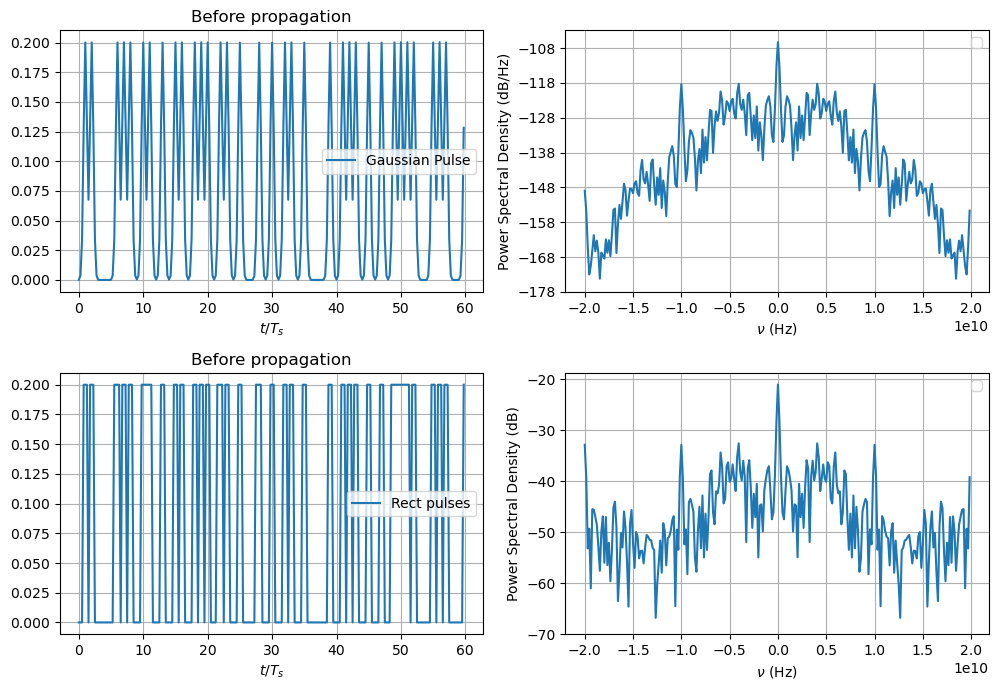

In [427]:
I_max = 40 * u.mA # maximum intensity value of diode laser 
I_nounit = I_max.to(u.A)/(1 * u.A)


bits_seq = np.random.randint(2, size=80) # np.array([0,1,0]) #   
bits_sended_lenght = len(bits_seq)

τ = .375 / B # caracteristic time of the gaussian pulse
τ_nounit = τ.to(u.s/u.bit)/(1 * u.s/u.bit)

def generate_gaussian_pulse(duration, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate) 
    pulse = np.sqrt(I_nounit) * np.array([np.sum([bits_seq[k] * np.exp(-((ti-k/B_nounit)/τ_nounit)**2) for k in range(bits_sended_lenght)]) for ti in t])
    return t, pulse



Π = lambda t: 1.0 if np.abs(t)<.5 else 0.0 # Unitary rectangular window
def generate_rectangular_pulses(duration, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate) 
    pulse = np.sqrt(I_nounit) * np.array([np.sum([bits_seq[k] * Π((ti * B_nounit - k)) for k in range(bits_sended_lenght)]) for ti in t])
    return time, pulse


###  TEMPOREL ###
# Paramètres du pulse
duration = 2 * bits_sended_lenght * τ_nounit   # time window (in seconds)
sampling_rate = 4 * B_nounit  # sampling frequency (in Hz)

# Générer le pulse gaussien
time, gaussian_pulse = generate_gaussian_pulse(duration, sampling_rate)
time, rect_pulse = generate_rectangular_pulses(duration, sampling_rate)






# Tracer le résultat
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
plt.plot(time * B_nounit, gaussian_pulse, label='Gaussian Pulse')
plt.title(f'Before propagation') #bits_seq
plt.xlabel(r'$t/T_s$')
plt.legend()
plt.grid(True)


plt.subplot(2,2,3)
plt.plot(time * B_nounit, rect_pulse, label='Rect pulses')
plt.title(f'Before propagation') #bits_seq
plt.xlabel(r'$t/T_s$')
plt.legend()
plt.grid(True)



###  SPECTRAL ###

"""
freq = np.fft.fftfreq(len(time), d=1/sampling_rate)
ω = 2 * np.pi * freq * u.Hz
fft_gauss_pulse = np.fft.fft(gaussian_pulse) 
fft_rect_pulse = np.fft.fft(rect_pulse)
"""



plt.subplot(2,2,2)
# plt.plot(freq, np.abs(fft_gauss_pulse), label=r'$|\hat{A}(\nu)|$')
plt.psd(gaussian_pulse, Fs=sampling_rate.value, sides='twosided')
plt.xlabel(r'$\nu$ (Hz)')
plt.legend()
plt.grid(True)


plt.subplot(2,2,4)
#plt.plot(freq, np.abs(fft_rect_pulse), label=r'$|\hat{A}(\nu)|$')
plt.psd(rect_pulse, Fs=sampling_rate.value, sides='twosided', scale_by_freq=False)
plt.xlabel(r'$\nu$ (Hz)')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

### Eye Diagram

In [428]:
def eye_diagram(data, sampling_rate,  time_eye_window_max):
    data_duration = len(data)/sampling_rate
    data_time = np.arange(0,data_duration, 1/sampling_rate)
    window = np.arange(0, time_eye_window_max, 1/sampling_rate)
    window[-1]=np.nan
    time_eye_value = np.array([window for i in range(int(np.floor(data_duration/time_eye_window_max)))]).flatten()
    time_eye_value = np.concatenate((time_eye_value, window[0 : len(data_time) - len(time_eye_value)]))

    plt.plot(time_eye_value, data)
    #plt.plot(time * B_nounit, rect_pulse, label='Rect pulses')
    #plt.title(f'Before propagation : Eye diagram') 
    plt.xlabel(r'$t$ [s]')
    #plt.ylabel('Envelop')
    plt.legend()
    plt.grid(True)
    

No handles with labels found to put in legend.


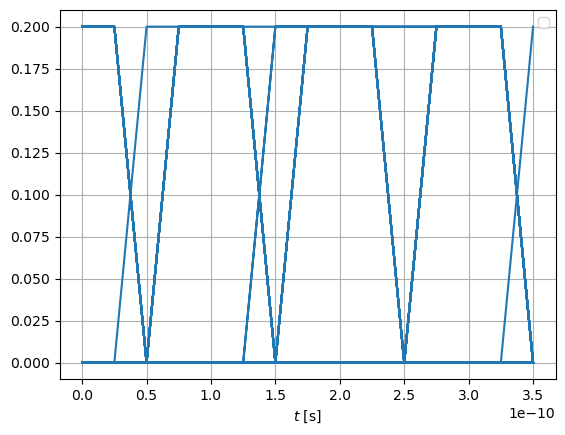

In [430]:
eye_diagram(rect_pulse, sampling_rate, 4 * 1/B_nounit)

In [435]:
freq = np.fft.fftfreq(len(time), d=1/sampling_rate)

#ω = 2 * np.pi * const.c/λ
ω = 2 * np.pi * freq * u.Hz
fft_gauss_pulse_prop = np.fft.fft(gaussian_pulse) * np.exp(1j * (β_2 * ω**2 * L/2).to(u.dimensionless_unscaled))
fft_rect_pulse_prop = np.fft.fft(rect_pulse) * np.exp(1j * (β_2 * ω**2 * L/2).to(u.dimensionless_unscaled))


gauss_pulse_prop = np.abs(np.fft.ifft(fft_gauss_pulse_prop))
rect_pulse_prop = np.abs(np.fft.ifft(fft_rect_pulse_prop))

No handles with labels found to put in legend.


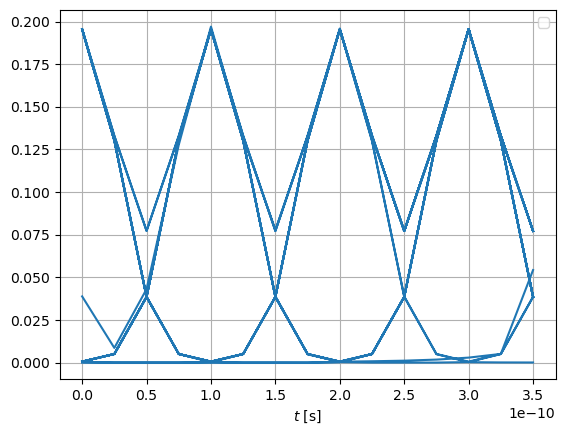

In [438]:
eye_diagram(gauss_pulse_prop, sampling_rate, 4 * 1/B_nounit)

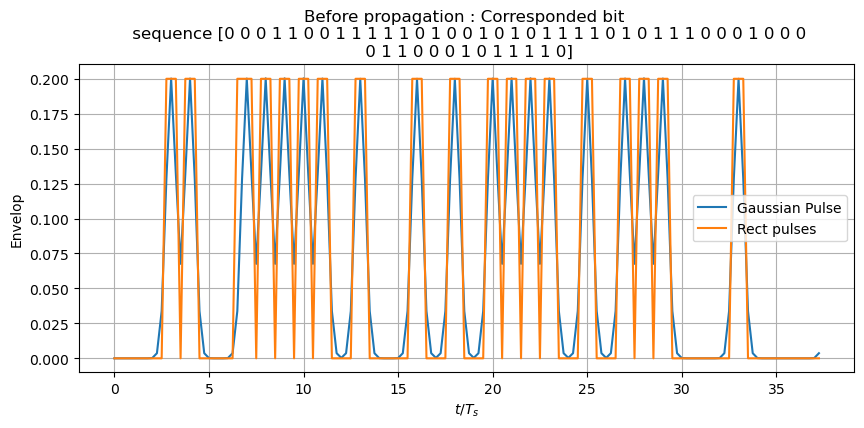

In [376]:
"""
plt.figure(figsize=(10, 4))

plt.plot(time * B_nounit, np.abs(gauss_pulse_prop), label='Gaussian Pulse')
plt.plot(time * B_nounit, np.abs(rect_pulse_prop), label='Rect pulses')
plt.title(f'Before propagation : Corresponded bit \n sequence {bits_seq}')
plt.xlabel(r'$t/T_s$')
plt.ylabel('Envelop')
plt.legend()
plt.grid(True)
plt.show()
"""

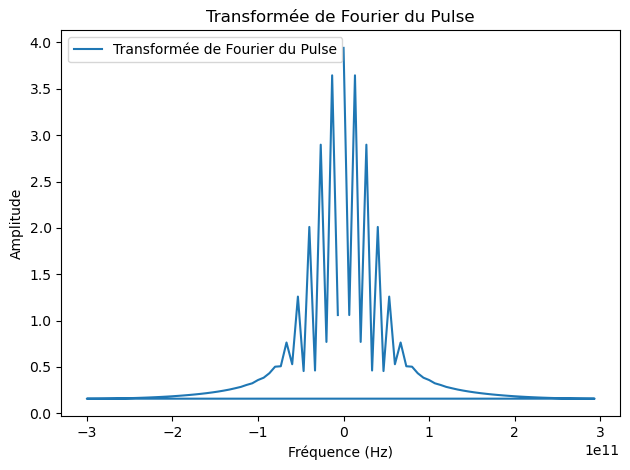

In [270]:
plt.plot(freq, np.abs(fft_gauss_pulse_prop), label='Transformée de Fourier du Pulse')
plt.title('Transformée de Fourier du Pulse')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

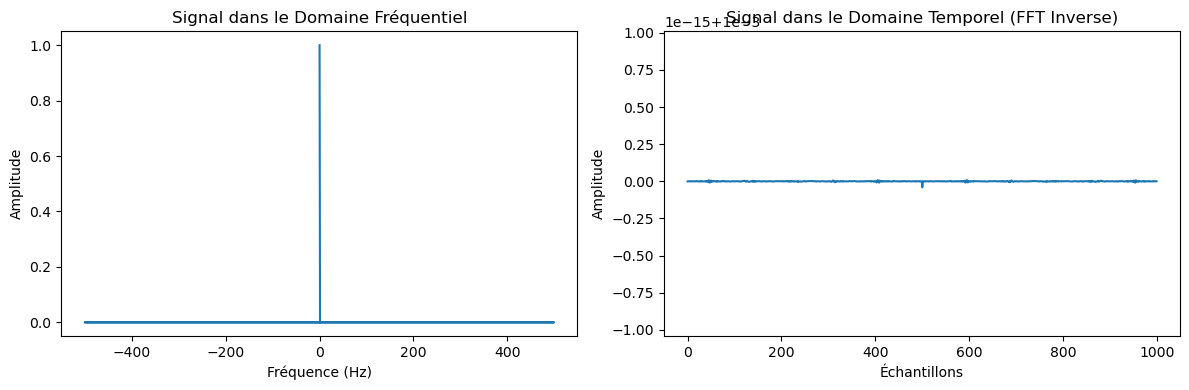

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Générer un signal dans le domaine fréquentiel
freq = np.fft.fftfreq(1000, 1/1000)  # Fréquences de -500 Hz à 499 Hz
signal_frequentiel = np.sinc(freq)  # Exemple : signal sinc

# Calculer la FFT inverse pour revenir dans le domaine temporel
signal_temporel = np.fft.ifft(signal_frequentiel)

# Tracer le signal temporel
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(freq, np.abs(signal_frequentiel))
plt.title('Signal dans le Domaine Fréquentiel')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
plt.plot(np.real(signal_temporel))
plt.title('Signal dans le Domaine Temporel (FFT Inverse)')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
